# Análisis de algunas propiedades estadísticas y probabilísticas del ticker AAPL

Apple Inc., cuyo ticker es AAPL, es una empresa tecnológica estadounidense que diseña y produce equipos electrónicos, software y servicios en línea. Tiene su sede principal en el Apple Park, en Cupertino, California, Estados Unidos. Sus productos de hardware incluyen el teléfono inteligente iPhone, la tableta iPad, la computadora personal Mac, entre otros.

En términos de su cotización en bolsa, AAPL se encuentra listada en el NASDAQ.

Fuente: [Apple -Wikipedia](https://es.wikipedia.org/wiki/Apple)

**Importancia del presente análisis**

A la hora de construir un portafolio de inversión hay varios riesgos involucrados, uno de ellos es el riesgo modelo, el cual representa la posibilidad de basar decisiones relativas a la construción del portafolio en modelos cuyas hipótesis no concuerden con lo observado en los datos con los que se quieren respaldar. Un caso particular que es de interés es el de modelar algunas propiedades de los retornos en un activo financiero que ayuden a tomar decisiones anticipadas con base en los datos presentes.
Por ello es necesario estudiar algunas propiedades de estos retornos, pues de esta forma es posible elegir un modelo que refleje de mejor manera sus propiedades a futuro o en alguna escala de tiempo de interés.

## Import data manipulation libraries

In [1]:
from plotly.offline import iplot
from plotly.subplots import make_subplots
from scipy import stats  # for QQ-plot, skewness, kurtosis
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

## Data extraction

Los datos se descargar a través de la **API** para Python de la plataforma [Yahoo Finance](http://finance.yahoo.com).

In [2]:
def download_ticker(ticker, start_date, end_date, column="Close"):
    """Download ticker data from yahoo finance

    Parameters
    ----------
    ticker: str
        Ticker symbol of the stock
    start_date: str
        Start date of the data
    end_date: str
        End date of the data
    column: str
        Column of the data to be downloaded

    Returns
    -------
    data: pd.Series
        Data of the ticker
    """

    df = yf.download(ticker, start=start_date, end=end_date, progress=True)

    data = df[column]

    return data

In [63]:
daily_data = download_ticker("AAPL", "2000-01-01", "2024-01-01")

[*********************100%%**********************]  1 of 1 completed


## Daily Close Price: AAPL

In [65]:
daily_data.iplot(kind="line", title="Apple Stock Daily Close Value", xTitle="Date", yTitle="Price")

En términos generales se puede ver que el precio de la acción **AAPL** ha tenido una tendencia creciente en el largo plazo, con una aparente aceleración en el aumento de su precio alrededor del 2019, y un cambio negativo de pendiente alrededor del 2022.

## Resampling to deriver weekly, monthly and anually values from daily data

### Weekly resampling

In [66]:
# Weekly price, indexed by number of week and the year

weekly_data = daily_data.resample("W-FRI").last().to_frame()
weekly_data["Year"] = weekly_data.index.year
weekly_data["Week_Number"] = weekly_data.index.isocalendar().week
weekly_data = weekly_data.sort_values(["Year", "Week_Number"])
weekly_data = weekly_data.set_index(["Year", "Week_Number"])
weekly_data.columns = ["Weekly_Close"]

weekly_data.iplot(kind="line", title="Apple Stock Weekly Close Value (Friday)", xTitle="Year / Number of week by year", yTitle="Price")

### Monthly Resampling

In [67]:
# Monthly price, indexed by month and the year

monthly_data = daily_data.resample("M").last().to_frame()
monthly_data["Year"] = monthly_data.index.year
monthly_data["Month"] = monthly_data.index.month_name()
monthly_data = monthly_data.sort_values(["Year", "Month"])
monthly_data = monthly_data.set_index(["Year", "Month"])
monthly_data.columns = ["Monthly_Close"]

monthly_data.iplot(kind="line", title="Apple Stock Monthly Close Value", xTitle="Date", yTitle="Price")

### Annually resampling

In [68]:
# Annually Price

annual_data = daily_data.resample("Y").last().to_frame()
annual_data["Year"] = annual_data.index.year
annual_data = annual_data.set_index(["Year"])
annual_data.columns = ["Annual_Close"]

annual_data.iplot(kind="line", title="Apple Stock Annual Close Value", xTitle="Year", yTitle="Price")

Como es esperado, al remuestrear los datos en ventanas más grandes de tiempo, visualmente se reduce la variabilidad local, visto desde una escala global.

En cierta forma eso nos permite ver más limpia la tendencia en la evolución del precio del activo.

## Calculating Log Returns

In [69]:
# Calculating Log Returns for Daily Data, Weekly Data, Monthly Data and Annual Data

def log_normal_returns(data):
    """Calculate log normal returns

    Parameters
    ----------
    data: pd.Series
        Data of the ticker

    Returns
    -------
    data: pd.Series
        Log normal returns of the ticker
    """

    return np.log(data).diff().dropna()

daily_log_returns = log_normal_returns(daily_data)
weekly_log_returns = log_normal_returns(weekly_data["Weekly_Close"])
monthly_log_returns = log_normal_returns(monthly_data["Monthly_Close"])
annual_log_returns = log_normal_returns(annual_data["Annual_Close"])

In [70]:
# Plotting Log Returns for Daily Data, Weekly Data, Monthly Data and Annual Data

fig = make_subplots(rows=2, cols=2, subplot_titles=("Daily", "Weekly", "Monthly", "Annual"))

fig1 = daily_log_returns.iplot(kind="line", title="Apple Stock Daily Log Returns", xTitle="Date", yTitle="Log Returns", asFigure=True)
fig.append_trace(fig1['data'][0], 1, 1)

fig2 = weekly_log_returns.iplot(kind="line", title="Apple Stock Weekly Log Returns", xTitle="Date", yTitle="Log Returns", asFigure=True)
fig.append_trace(fig2['data'][0], 1, 2)

fig3 = monthly_log_returns.iplot(kind="line", title="Apple Stock Monthly Log Returns", xTitle="Date", yTitle="Log Returns", asFigure=True)
fig.append_trace(fig3['data'][0], 2, 1)

fig4 = annual_log_returns.iplot(kind="line", title="Apple Stock Annual Log Returns", xTitle="Date", yTitle="Log Returns", asFigure=True)
fig.append_trace(fig4['data'][0], 2, 2)

fig.update_layout(height=1000, width=1200, title_text="Apple Stock Log Returns (2008-2021) resampling comparison", title_x=0.5)

iplot(fig)

Como sabemos que los retornos por lo general siguen distribuciones con colas pesadas, aplicamos una transformación logarítmica previamente para reducir la varianza, "comprimir" los valores extremos y "expandir" los valores pequeños para, en este caso tener una distribución cualitativamente más parecida a una normal. Sin embargo, veremos que cuantitativamente no siempre es una buena distribución para comparar estos datos, salvo en algunas escalas de tiempo específicas.

## Log Returns histograms

In [71]:
# Plotting histogram of Log Returns for Daily Data, Weekly Data, Monthly Data and Annual Data

fig = make_subplots(rows=2, cols=2, subplot_titles=("Daily", "Weekly", "Monthly", "Annual"))

fig1 = daily_log_returns.iplot(kind='histogram', title = 'Histogram of Daily Returns', asFigure=True)
fig.append_trace(fig1['data'][0], 1, 1)

fig2 = weekly_log_returns.iplot(kind="histogram", title="Histogram of Weekly Returns", asFigure=True)
fig.append_trace(fig2['data'][0], 1, 2)

fig3 = monthly_log_returns.iplot(kind="histogram", title="Histogram of Monthly Returns", asFigure=True, bins=30)
fig.append_trace(fig3['data'][0], 2, 1)

fig4 = annual_log_returns.iplot(kind="histogram", title="Histogram of Annual Returns", asFigure=True, bins=7)
fig.append_trace(fig4['data'][0], 2, 2)

fig.update_layout(height=1000, width=1200, title_text="Apple Stock Log Returns (2008-2021) empirical distributions", title_x=0.5)

iplot(fig)


Siguiendo lo anterior, tras un análisis visual de la distribución empírica podría pensarse que los datos siguen una distribución normal o alguna cualitativament parecida.

## Moments comparison

In [72]:
# Calculating moments of the data

def calculate_moments(data):
    """Calculate moments of the data

    Parameters
    ----------
    data: pd.Series
        Data of the ticker

    Returns
    -------
    moments: dict
        Dictionary of moments
    """
    moments = {
    'Mean': np.mean(data),
    'SD': np.std(data),
    'Kurtosis': stats.kurtosis(data,fisher=True),
    'Skew': stats.skew(data)
    }
    return moments

momemts_daily = calculate_moments(daily_log_returns)
momemts_weekly = calculate_moments(weekly_log_returns)
momemts_monthly = calculate_moments(monthly_log_returns)
momemts_annual = calculate_moments(annual_log_returns)

data_moments = pd.DataFrame([momemts_daily, momemts_weekly, momemts_monthly, momemts_annual], index=["Daily", "Weekly", "Monthly", "Annual"])
data_moments

,Mean,SD,Kurtosis,Skew
Daily,0.000872,0.025611,113.828035,-4.007767
Weekly,0.004299,0.057383,25.662572,-1.698386
Monthly,0.017563,0.273294,5.333932,-0.563950
Annual,0.286344,0.436591,0.374891,-0.493625


## Standarizing time series

In [73]:
# Standarizing data

def standarize_data(data):
    """Standarize input data
    with mean 0 and standard deviation 1

    Parameters
    ----------
    data: pd.Series
        Data of the ticker

    Returns
    -------
    standarized_data: pd.Series
        Standarized data of the ticker
    """
    mean = np.mean(data)

    std = np.std(data)

    standarized_data = (data - mean) / std

    return standarized_data


standarized_daily_returns = standarize_data(daily_log_returns)
standarized_weekly_returns = standarize_data(weekly_log_returns)
standarized_monthly_returns = standarize_data(monthly_log_returns)
standarized_annual_returns = standarize_data(annual_log_returns)

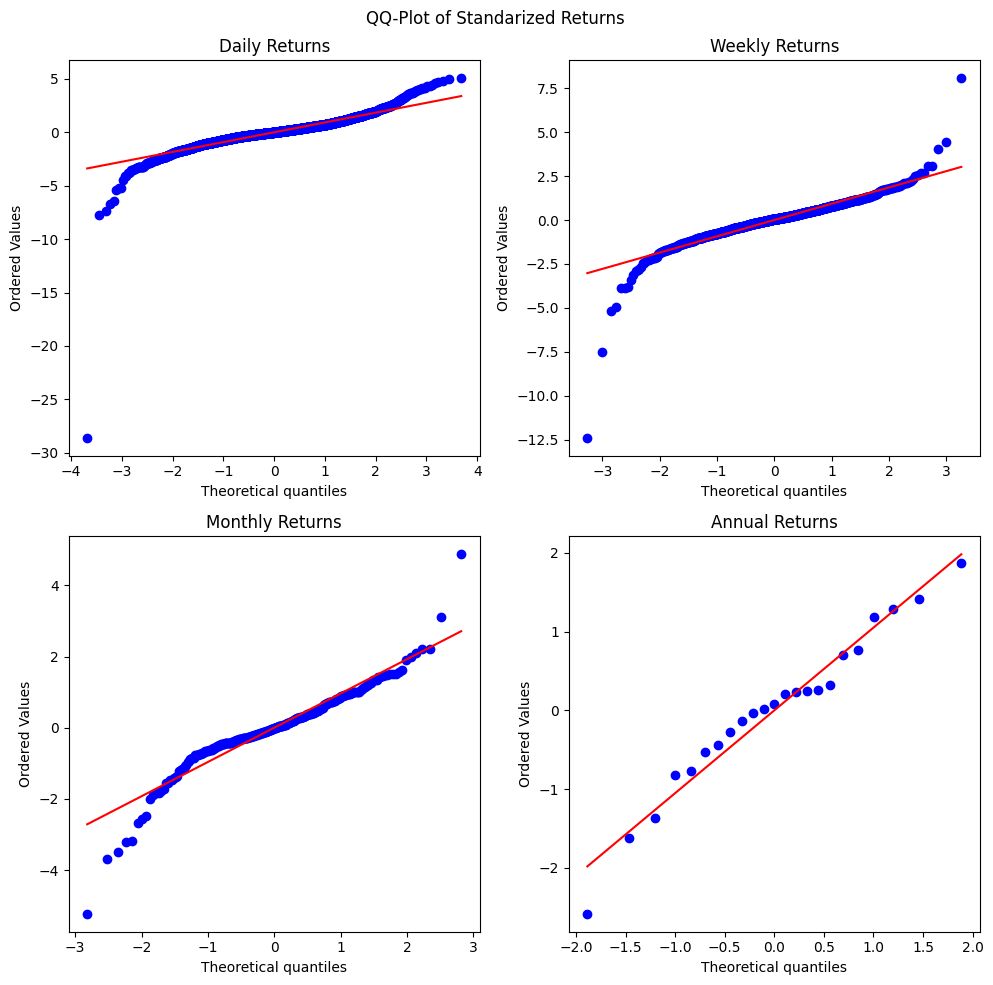

In [74]:
# Plotting QQ-plot of Standarized Log Returns

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

stats.probplot(standarized_daily_returns, plot=ax[0, 0])
ax[0, 0].set_title("Daily Returns")

stats.probplot(standarized_weekly_returns, plot=ax[0, 1])
ax[0, 1].set_title("Weekly Returns")

stats.probplot(standarized_monthly_returns, plot=ax[1, 0])
ax[1, 0].set_title("Monthly Returns")

stats.probplot(standarized_annual_returns, plot=ax[1, 1])
ax[1, 1].set_title("Annual Returns")

plt.suptitle("QQ-Plot of Standarized Returns")
plt.tight_layout()
plt.show()

## Autocoorelation of normalized log returns

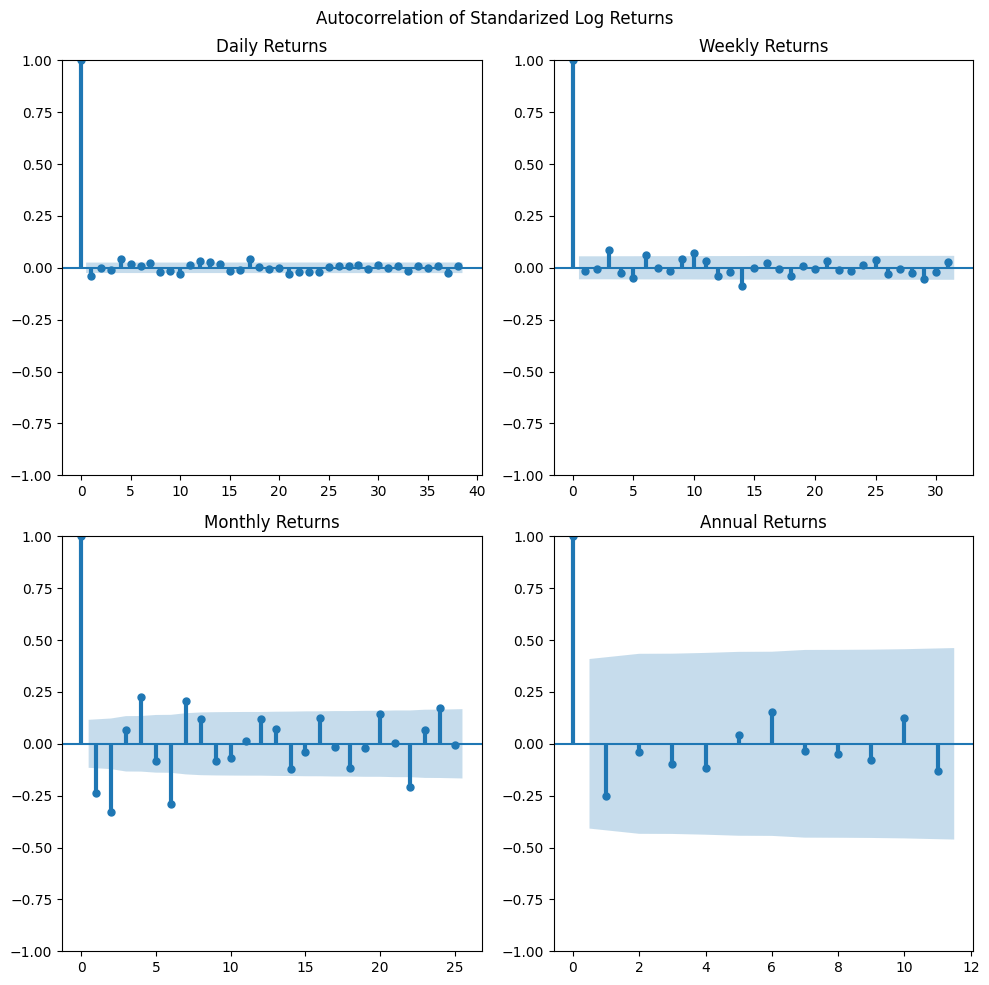

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_acf(standarized_daily_returns, vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Daily Returns', ax=ax[0, 0])
ax[0, 0].set_title("Daily Returns")

plot_acf(standarized_weekly_returns, vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Weekly Returns', ax=ax[0, 1])
ax[0, 1].set_title("Weekly Returns")

plot_acf(standarized_monthly_returns, vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Monthly Returns', ax=ax[1, 0])
ax[1, 0].set_title("Monthly Returns")

plot_acf(standarized_annual_returns, vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Annual Returns', ax=ax[1, 1])
ax[1, 1].set_title("Annual Returns")

plt.suptitle("Autocorrelation of Standarized Log Returns")
plt.tight_layout()

plt.show()

## Autocoorelation of absolute value of normalized log returns

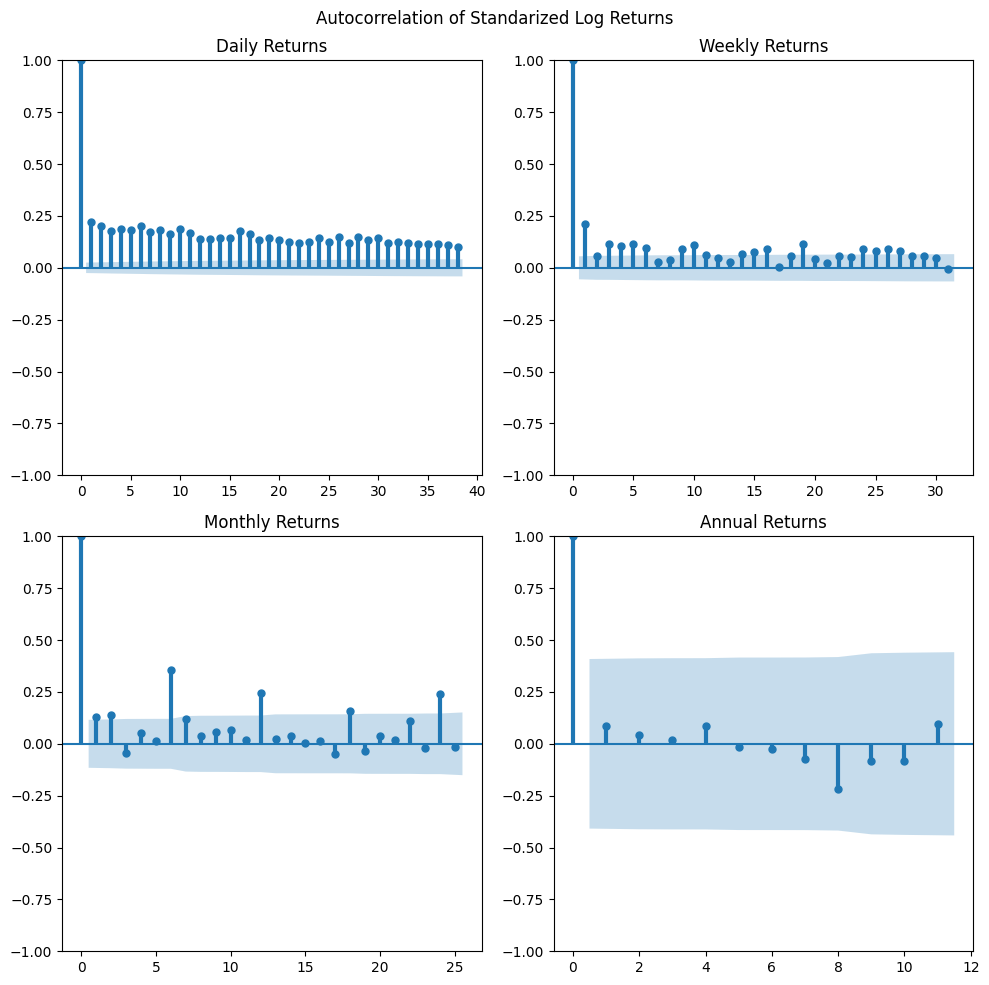

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_acf(abs(standarized_daily_returns), vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Daily Returns Abs. Value', ax=ax[0, 0])
ax[0, 0].set_title("Daily Returns")

plot_acf(abs(standarized_weekly_returns), vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Weekly Returns Abs. Value', ax=ax[0, 1])
ax[0, 1].set_title("Weekly Returns")

plot_acf(abs(standarized_monthly_returns), vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Monthly Returns Abs. Value', ax=ax[1, 0])
ax[1, 0].set_title("Monthly Returns")

plot_acf(abs(standarized_annual_returns), vlines_kwargs={'linewidth': 3}, title='Autocorrelation of Annual Returns Abs. Value', ax=ax[1, 1])
ax[1, 1].set_title("Annual Returns")

plt.suptitle("Autocorrelation of Standarized Log Returns")
plt.tight_layout()

plt.show()

## Conclusiones



De la información recopilada anteriormente y dando una breve recapitulación de lo que arrojó el análisis anterior podemos observar que , el comportamiento del precio de las acciones de Apple se ha movilizado por una tendencia general al alza, con cambios apreciables en diferentes periodicidades de tiempo, y la distribución de los retornos ha sido transformada para facilitar el análisis, pero su idoneidad depende de la escala de tiempo específica que se esté considerando.

También debemos tener en cuenta que el precio de las acciones de dicha compañía son muy volátiles y debido a su inestabilidad en el mercado se puede mencionar que estas van a presentar un mayor riesgo presentando variaciones más notorias que activos financieros más estables.

Cabe resaltar de igual manera que para una distribución normal la curtosis debe ser κ = 3, sin embargo, dentro de las periodicidades analizadas, existen notables diferencias, siendo que para el diario y el semanal se indica una distribución leptucurtica con menor concentración en la mediana, y colas pesadas.

Por otro lado para el anual se presenta un valor por debajo de κ = 3, lo que nos habla de una distribución platicurtica con mayor distribución en la mediana y colas ligeras.

Finalmente, aunque para el periodo mensual sigue siendo una distribución platicurtica con mayor distribución en la mediana y colas ligeras, su valor no dista considerablemente de una curtosis ideal para una distribución normal.

